In [1]:
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt

from math import log, sqrt
from collections import deque
from kaggle_environments import make
from jupyterplot import ProgressPlot

Loading environment football failed: No module named 'gfootball'


In [2]:
def ucb(value, visits, parent_visits):
    if visits == 0 or parent_visits == 0:
        return float('inf')
    
    v = value / visits
    
    return v + 2 * sqrt(log(parent_visits) / visits)


class MCTS():
    def __init__(self):
        self.tree = dict()
        
    def has_state(self, state):
        return state in self.tree
    
    def add_state(self, state):
        self.tree[state] = MCTSNode()
    
    def get_action(self, state):
        return self.tree[state].choose_action()
    
    def update_state(self, state, value, action):
        self.tree[state].visits += 1
        self.tree[state].actions[action][0] += 1
        self.tree[state].actions[action][1] += value
        
    
class MCTSNode():
    def __init__(self):
        self.visits = 0
        self.actions = [[0, 0] for _ in range(7)] # visits, acc_value
    
    def choose_action(self):
        actions_ucb = [ucb(value, visits, self.visits) for visits, value in self.actions]
        idx = np.argmax(actions_ucb)
        return int(idx)
        
    
def play(n_epochs):
    env = make("connectx", debug=False)
    
    trainer = env.train([None, 'random'])
    config = trainer.reset()
    
    mcts_tree = MCTS()
    mcts_tree.add_state(tuple(config.board))
    
    pp = ProgressPlot(line_names=["wins", "ties", "losses"])
    wins, ties, losses = 0, 0, 0
    results = [0 for _ in range(n_epochs)]
    
    for i in range(n_epochs):            
        state_hist, next_state, game_over, reward = traverse(trainer, mcts_tree)
        
        if not game_over:
            reward = rollout(trainer)
            mcts_tree.add_state(next_state)
            
        reward = process_reward(reward)
        
        for state, action in state_hist:
            mcts_tree.update_state(state, reward, action)
        
        results[i] = reward
        
        if reward == 2:
            wins += 1
        elif reward == 1:
            ties += 1
        else:
            losses += 1
            
        pp.update([[wins, ties, losses]])
    
    pp.finalize()
    
    return mcts_tree, results


def process_reward(reward):
    if reward == None or reward < 0:
        return -1
    
    if reward == 0:
        return 1
    
    return 2


def traverse(trainer, tree):
    config = trainer.reset()    
    state = tuple(config.board)
    
    state_hist = []
    game_over = False
    reward = 0
    
    while tree.has_state(state) and not game_over:
        action = tree.get_action(state)
        state_hist.append((state, action))
        
        config = trainer.step(action)
        state = tuple(config[0].board)
        game_over = config[2]
        reward = config[1]
    
    next_state = state if not game_over else None
        
    return state_hist, next_state, game_over, reward


def rollout(trainer):
    game_over = False
    reward = 0
    
    while not game_over:
        action = random.randrange(7)
        config = trainer.step(action)
        reward = config[1]
        game_over = config[2]
    
    return reward

In [3]:
tree, results = play(n_epochs=100000)

In [4]:
losses = np.cumsum((np.array(results) == -1))
ties = np.cumsum((np.array(results) == 1))
wins = np.cumsum(np.array(results) == 2)

losses.shape, ties.shape, wins.shape

((100000,), (100000,), (100000,))

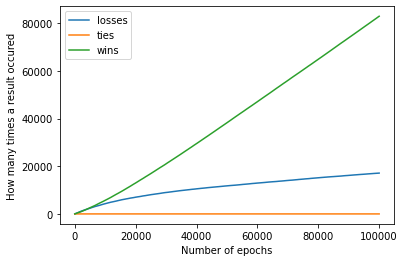

In [5]:
plt.plot(losses, label='losses')
plt.plot(ties, label='ties')
plt.plot(wins, label='wins')

plt.legend()
plt.ylabel('How many times a result occured')
plt.xlabel('Number of epochs')

plt.show()

In [8]:
with open('ConnectFour-Env_Random_RTPlot.pkl', 'wb') as model_file:
    pickle.dump(tree, model_file, pickle.HIGHEST_PROTOCOL)